In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from stats import *

from sklearn.metrics import roc_curve

from IPython.core.display import display, HTML
display(HTML('<style>.container { width:90% !important; }</style>'))

### Import predictions

In [2]:
morgan = pd.read_excel('predictions-morgan.xlsx', sheet_name='morgan')
morgan.rename(columns={'Prediction': 'morgan', 'AD': "morgan_ad"}, inplace=True)
morgan.head(1)

,Compound_name,InChIKey,Molecule ChEMBL ID,Outcome,SMILES,Set,Standard Relation,Standard Type,Standard Units,Standard Value,morgan,morgan_ad
0,NaN,AEYIBAPLFDNVGD-UHFFFAOYNA-N,NaN,1,CC(=O)NC(CO)C(=O)NC(C)C(=O)NC(C(=O)NC(CC(C)C)C...,train,0,IC50,nM,5700.0,1,1.0


In [3]:
sirms_dragon = pd.read_excel('predictions-sirms-dragon.xlsx', sheet_name='sirms-dragon')
#morgan.rename(columns={'s': 'Morgan', 'AD': "Morgan_AD", 'Confidence': 'Morgan_Conf'}, inplace=True)

sirms_dragon.head(1)

,Compound_name,Standard Type,Standard Relation,Standard Value,Standard Units,Outcome,InChIKey,Molecule ChEMBL ID,SMILES,sirms,sirms_ad,dragon,dragon_ad,consensus,consensus_ad,consensus_rigor
0,NaN,IC50,0,5700.0,nM,1,AEYIBAPLFDNVGD-UHFFFAOYNA-N,NaN,CC(=O)NC(CO)C(=O)NC(C)C(=O)NC(C(=O)NC(CC(C)C)C...,1,1.0,1,1.0,1,1.0,1.0


In [4]:
sirms_dragon = sirms_dragon[['Compound_name', 'Molecule ChEMBL ID', 'Outcome', 'SMILES', 'InChIKey', 'sirms', 'sirms_ad', 'dragon', 'dragon_ad']]
predictions = pd.merge(sirms_dragon, morgan[['InChIKey', 'morgan', 'morgan_ad']], on='InChIKey')
predictions.head()

,Compound_name,Molecule ChEMBL ID,Outcome,SMILES,InChIKey,sirms,sirms_ad,dragon,dragon_ad,morgan,morgan_ad
0,NaN,NaN,1,CC(=O)NC(CO)C(=O)NC(C)C(=O)NC(C(=O)NC(CC(C)C)C...,AEYIBAPLFDNVGD-UHFFFAOYNA-N,1,1.0,1,1.0,1,1.0
1,(2R)-2-(4-acetamido-N-[2-(benzotriazol-1-yl)ac...,NaN,1,CCC(C)(C)NC(=O)C(c1cccn1C)N(C(=O)Cn1nnc2ccccc2...,BCIIGGMNYNWRQK-UHFFFAOYSA-N,1,NaN,0,NaN,0,NaN
2,NaN,NaN,0,Cc1cc(C(=O)NC(C)C(=O)NC(C(=O)NC(CC(C)C)C(=O)NC...,BEDKZMYJXHXMQM-OPEKNORGSA-N,0,NaN,1,NaN,0,NaN
3,(2S)-N-[(2S)-1-hydroxy-3-phenylpropan-2-yl]-3-...,NaN,1,O=C(C=Cc1ccccc1)NC(Cc1ccccc1)C(=O)NC(CO)Cc1ccccc1,GEVQDXBVGFGWFA-UHFFFAOYSA-N,1,NaN,0,NaN,0,NaN
4,NaN,NaN,0,CC(=O)NC(CC(=O)O)C(=O)NC(CO)C(=O)NC(Cc1ccccc1)...,HYACKLDVAOZFRF-UHFFFAOYSA-N,1,1.0,1,NaN,0,NaN


In [5]:
for col in predictions.columns:
    predictions[col].replace('Inactive',0,inplace=True)
    predictions[col].replace('Active',1,inplace=True)

### Consensus

In [6]:
# Consensus
predictions['consensus'] = (predictions.sirms + predictions.dragon + predictions.morgan)/3
predictions['consensus'] = np.where(predictions['consensus'] > 0.5, 1, 0)

In [7]:
# Consensus AD
for i in range(0, predictions.shape[0]):
    if all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.dragon_ad[i]) == False, np.isnan(predictions.morgan_ad[i]) == False]):
        predictions.loc[i,'consensus_ad'] = (predictions.sirms_ad[i] + predictions.dragon_ad[i] + predictions.morgan_ad[i])/3
        predictions.loc[i,'consensus_ad'] = np.where(predictions.loc[i,'consensus_ad'] > 0.5, 1, 0)
    elif all([np.isnan(predictions.sirms_ad[i]) == True, np.isnan(predictions.dragon_ad[i]) == False, np.isnan(predictions.morgan_ad[i]) == False]):
        predictions.loc[i,'consensus_ad'] = (predictions.dragon_ad[i] + predictions.morgan_ad[i])/2
        predictions.loc[i,'consensus_ad'] = np.where(predictions.loc[i,'consensus_ad'] > 0.5, 1, 0)
    elif all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.dragon_ad[i]) == True, np.isnan(predictions.morgan_ad[i]) == False]):
        predictions.loc[i,'consensus_ad'] = (predictions.sirms_ad[i] + predictions.morgan_ad[i])/2
        predictions.loc[i,'consensus_ad'] = np.where(predictions.loc[i,'consensus_ad'] > 0.5, 1, 0)
    elif all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.dragon_ad[i]) == False, np.isnan(predictions.morgan_ad[i]) == True]):
        predictions.loc[i,'consensus_ad'] = (predictions.sirms_ad[i] + predictions.dragon_ad[i])/2
        predictions.loc[i,'consensus_ad'] = np.where(predictions.loc[i,'consensus_ad'] > 0.5, 1, 0)
    elif all([np.isnan(predictions.sirms_ad[i]) == False, np.isnan(predictions.dragon_ad[i]) == True, np.isnan(predictions.morgan_ad[i]) == True]):
        predictions.loc[i,'consensus_ad'] = predictions.sirms_ad[i]
    elif all([np.isnan(predictions.sirms_ad[i]) == True, np.isnan(predictions.dragon_ad[i]) == False, np.isnan(predictions.morgan_ad[i]) == True]):
        predictions.loc[i,'consensus_ad'] = predictions.dragon_ad[i]
    elif all([np.isnan(predictions.sirms_ad[i]) == True, np.isnan(predictions.dragon_ad[i]) == True, np.isnan(predictions.morgan_ad[i]) == False]):
        predictions.loc[i,'consensus_ad'] = predictions.morgan_ad[i]
    else:
        predictions.loc[i,'consensus_ad']  = np.nan

In [8]:
### Calculate stats

In [9]:
# morgan stats
morgan = pd.DataFrame(stats(predictions['Outcome'], predictions['morgan'])).round(2)
morgan['Coverage'] = 1.0

# morgan AD stats
morgan_ad = predictions.dropna(subset=['morgan_ad'])
coverage_morgan_ad = len(morgan_ad['morgan_ad']) / len(predictions['Outcome'])
morgan_ad = pd.DataFrame(stats(morgan_ad['Outcome'], morgan_ad['morgan_ad'])).round(2)
morgan_ad['Coverage'] = round(coverage_morgan_ad, 2)

# print stats
morgan_5f_stats = morgan.append(morgan_ad)
morgan_5f_stats.set_index([['Morgan', 'Morgan AD']], drop=True, inplace=True)

# sirms stats
sirms = pd.DataFrame(stats(predictions['Outcome'], predictions['sirms'])).round(2)
sirms['Coverage'] = 1.0

# sirms AD stats
sirms_ad = predictions.dropna(subset=['sirms_ad'])
coverage_sirms_ad = len(sirms_ad['sirms_ad']) / len(predictions['Outcome'])
sirms_ad = pd.DataFrame(stats(sirms_ad['Outcome'], sirms_ad['sirms_ad'])).round(2)
sirms_ad['Coverage'] = round(coverage_sirms_ad, 2)

# print stats
sirms_5f_stats = sirms.append(sirms_ad)
sirms_5f_stats.set_index([['sirms', 'sirms AD']], drop=True, inplace=True)

# dragon stats
dragon = pd.DataFrame(stats(predictions['Outcome'], predictions['dragon'])).round(2)
dragon['Coverage'] = 1.0

# dragon AD stats
dragon_ad = predictions.dropna(subset=['dragon_ad'])
coverage_dragon_ad = len(dragon_ad['dragon_ad']) / len(predictions['Outcome'])
dragon_ad = pd.DataFrame(stats(dragon_ad['Outcome'], dragon_ad['dragon_ad'])).round(2)
dragon_ad['Coverage'] = round(coverage_dragon_ad, 2)

# print stats
dragon_5f_stats = dragon.append(dragon_ad)
dragon_5f_stats.set_index([['dragon', 'dragon AD']], drop=True, inplace=True)

# consensus stats
consensus = pd.DataFrame(stats(predictions['Outcome'], predictions['consensus'])).round(2)
consensus['Coverage'] = 1.0

# consensus AD stats
consensus_ad = predictions.dropna(subset=['consensus_ad'])
coverage_consensus_ad = len(consensus_ad['consensus_ad']) / len(predictions['Outcome'])
consensus_ad = pd.DataFrame(stats(consensus_ad['Outcome'], consensus_ad['consensus_ad'])).round(2)
consensus_ad['Coverage'] = round(coverage_consensus_ad, 2)

# print stats
consensus_5f_stats = consensus.append(consensus_ad)
consensus_5f_stats.set_index([['consensus', 'consensus AD']], drop=True, inplace=True)

In [10]:
stats = pd.concat([morgan_ad, sirms_ad, dragon_ad, consensus, consensus_ad], axis=0)
stats.set_index([['Morgan', 'SiRMS', 'Dragon', 'Consensus', 'Consensus (AD)']], drop=True, inplace=True)

stats

,Accuracy,AUC,Kappa,CCR,Sensitivity,PPV,Specificity,NPV,Coverage
Morgan,0.87,0.80,0.67,0.80,0.62,0.94,0.98,0.85,0.69
SiRMS,0.86,0.83,0.68,0.83,0.72,0.86,0.93,0.85,0.61
Dragon,0.89,0.78,0.65,0.78,0.56,1.00,1.00,0.87,0.54
Consensus,0.78,0.74,0.50,0.74,0.60,0.73,0.88,0.80,1.00
Consensus (AD),0.84,0.78,0.61,0.78,0.62,0.86,0.95,0.83,0.77


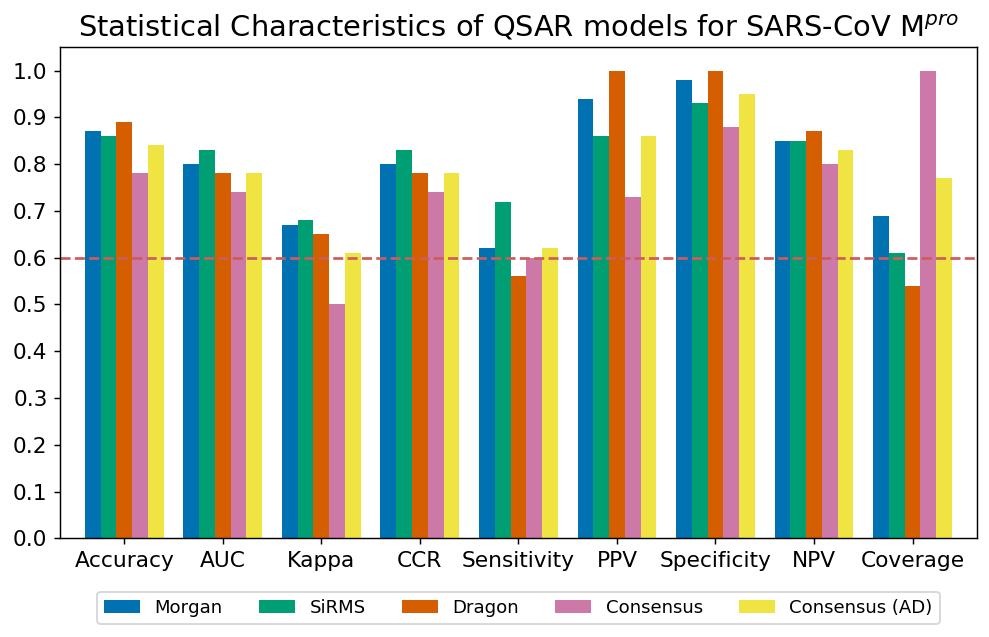

In [11]:
# Transpose stats
stats_t = stats.T
stats_t = stats_t.reset_index()
stats_t = stats_t.rename(columns={'index': 'Stats'})

# Make plot
plt.style.use('seaborn-colorblind')
fig, ax1 = plt.subplots(figsize=(8,5), dpi=130)

stats_t.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_xticklabels(labels=stats_t['Stats'].tolist(), fontsize=14, rotation=0)
ax1.axhline(y=.6, color='indianred', ls='dashed')
ax1.legend_.remove()
plt.title('Statistical Characteristics of QSAR models for SARS-CoV M$^{pro}$', fontsize=16)
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.tick_params(labelsize=12)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=10,
            loc='upper center', bbox_to_anchor=(0.5, -0.09), ncol=5)
fig.tight_layout()

plt.savefig('docs/statistics-qsar-models.png', bbox_inches='tight', transparent=False, format='png', dpi=300)
plt.show();